In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from astropy.time import Time
import os
from scipy.signal import lombscargle
from bokeh.palettes import viridis, inferno

from bokeh.plotting import output_notebook, figure, show
from bokeh.models import HoverTool, tools,ColumnDataSource, Whisker, ColorBar, LinearColorMapper
#output_notebook()

from bokeh.models import LogColorMapper, LogTicker, ColorBar
from bokeh.models.glyphs import Text
from astropy.timeseries import LombScargle

import matplotlib.pyplot as plt
#%matplotlib widget
# use seaborn for plot styles
import seaborn; seaborn.set()

from astropy import units as u
from astropy.coordinates import SkyCoord


from bokeh.models.ranges import Range1d

import aplpy
from PyAstronomy.pyTiming import pyPDM
output_notebook()


Loading BokehJS ...

In [2]:
def getobjectdata(datafile,index,name='name'):
    command = "sed '{}q;d'  {}".format(index+1,datafile)
    print(command)
    datastring = ! {command}
    datalist = datastring[0].split()
    print(datalist[2:4])
    return datalist



def getvegamaganddates(data,columnfile,name):
    vegamagindex = np.arange(28,1653,13)
    #vegamagindex = np.arange(28,6568,13)
    
    
    vegamaglist = np.array([float(data[i]) for i in vegamagindex])
    vegamaglisterrors = np.array([float(data[i+2]) for i in vegamagindex])
    
    photometricflag = np.array([float(data[i+8]) for i in vegamagindex])
    
    columns = []
    with open(columnfile) as filecol:
        for line in filecol:
            columns.append(line)
    listanames = []
    dates = []
    times =[]
    nameobject = []
    namel=[]

    for i in vegamagindex:
        initname = columns[i].find('Try/u')
        namefits = columns[i][initname:initname+23]
        listanames.append(namefits)
        fit = fits.open(namefits+'.fits')
        dates.append(fit[0].header['DATE-OBS'])
        times.append(fit[0].header['TIME-OBS'])
        namel.append(name)
    datesobs = [['{}T{}'.format(i,j)] for i,j in zip(dates,times)]

    d = np.array(datesobs)
    t = Time(d)
    namel = np.array(namel)
       
    return vegamaglist, vegamaglisterrors,t, d, namel, photometricflag


def createdatadiccomplete(data,columnfile):
    vegamag,vegamagerrros, timelist, observationname = getvegamaganddates(data,columnfile)
    datadic = {'time':timelist.datetime64,
               'VEGAMAG':vegamag,
               'obnames':observationname,
                'errorsmag':vegamagerrros}
    return datadic
            



def createdatadicclean(datafile,index,columnfile,name='name',timeformat='datetime64'):
    dataobject = getobjectdata(datafile,index)
    vegamag,vegamagerrros, timelist, observationname, namelist, photometricflag = getvegamaganddates(dataobject,columnfile,name)
    goodvegamagindex = np.where(vegamag < 99)[0]
    goodphotoindex = np.where(photometricflag == 0.)
    goodindex = np.intersect1d(goodvegamagindex,goodphotoindex)
    print(len(goodindex))
    if timeformat == 'datetime64':
        timelist2 = timelist.datetime64[goodindex]
    elif timeformat == 'mjd':
        timelist2 = timelist.mjd[goodindex]

    datadic = {'time':np.array(timelist2.flatten()),
               'VEGAMAG':vegamag[goodindex],
               'obnames':observationname[goodindex],
                'errorsmag':vegamagerrros[goodindex],
               'upper':vegamag[goodindex] + vegamagerrros[goodindex] ,
              'lower':vegamag[goodindex] - vegamagerrros[goodindex],
              'name':namelist[goodindex]}
    return datadic


def plotlb(outputfile,index,columnfile,name='',plot=True,getarg=False,periods=np.linspace(0.2, 1.4, 4000)):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

        # Choose a period grid
    periods = periods
    #periods = np.linspace(0.2, 1.4, 4000)
    ang_freqs = 2 * np.pi / periods

    # compute the (unnormalized) periodogram
    # note pre-centering of y values!
    power = lombscargle(t.flatten(), mag - mag.mean(), ang_freqs,normalize=False,precenter=True)

    # normalize the power
    N = len(t.flatten())
    #power *= 2 / (N * mag.std() ** 2)
    if plot == True:
        # plot the results
        fig, ax = plt.subplots()
        ax.plot(periods, power)
        ax.set(ylim=(0, 0.8), xlabel='period (days)',
               ylabel='Lomb-Scargle Power');
    if getarg == True:
        return periods, power,t,mag,dmag

def plotlc(outputfile,indexlist,columnfile,namelist=''):
    colorlist = ['red','blue','green','yellow']
    p = figure(plot_width=900, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
                  x_axis_type='datetime',y_axis_label='VEGAMAG',x_axis_label='Date_Obs')
    
    
    for i,indexnumber in enumerate(indexlist):
        color = colorlist[i]
        
        datagood = createdatadicclean(outputfile,indexnumber,columnfile,name=namelist[i])

        source = ColumnDataSource(data=datagood)
   


        


        #Tool to get wavelength
        hover2 = HoverTool(
                tooltips=[
                    ('Date', '(@obnames)')
                ]
            )


        p.add_tools(hover2)



        # add a circle renderer with a size, color, and alpha
        p.circle('time','VEGAMAG', source=source, color=color, name='name',legend='name')
        p.add_layout(
            Whisker(source=source, base="time", upper="upper", lower="lower")
        )


    p.y_range.flipped = True



    show(p)

def plotphase(outputfile,index,columnfile,name='',plot=False,periodmax=99.99, periods=np.linspace(0.2, 1.4, 4000),returnarg=False):
    nameob= name
    periods,power,t,mag,dmag = plotlb(outputfile,index,columnfile,name=nameob,plot=plot,getarg=True,periods=periods)
    #datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    #t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']
    indexmax = np.where(power == power.max())
    #print(periods)
    if periodmax == 99.99:
        periodmax = periods[indexmax]
    print(periodmax)

    # Compute phases of the obsevations
    phase = (t.flatten() / periodmax) % 1

    # Plot the phased data & model
    fig, ax = plt.subplots()

    
    ax.errorbar(phase, mag, dmag, fmt='.k', ecolor='gray', alpha=0.5)
    ax.invert_yaxis();
    plt.show()
    if returnarg:
        return phase,mag,dmag, t.flatten()
    
    
def plotlcseaborn(outputfile,index,columnfile,name='',invertaxis = False):
    datagoodmjd=  createdatadicclean(outputfile,index,columnfile,name=name,timeformat='mjd')
    
    
    t, mag, dmag = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag']

    
    
    fig, ax = plt.subplots()


    ax.errorbar(t, mag, dmag,  fmt='.k', ecolor='gray')
    ax.set(xlabel='Time (days)', ylabel='magitude',
           title=datagoodmjd['name'][0])
    if invertaxis == True:
        ax.invert_yaxis();
    plt.show()

In [3]:
outputfile = 'outdir/out.photo'
columnfile = 'outdir/out.columns'


# U19

# CMD

In [4]:
radeg = 265.1763125
decdeg = -53.6747203
separ = 0.0005

f275 = [ ]
f336 = [ ]
f606 = [ ]

radeglist = []
decdeglist = []
ind = []
name = []

cat = 'hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc6397_multi_v1_catalog-meth3.txt'

with open(cat,'r') as file:
    for index, line in enumerate(file):
    #for line in file:
        line = line.strip()
        if not line:  # line is blank
            continue
        if line.startswith("#"):  # comment line
            continue
        b = line.split()
        #if float(b[2]) != -99.9999 and float(b[8]) != -99.9999 and float(b[32]) > 90.:
        if float(b[2]) != -99.9999 and float(b[8]) != -99.9999:

            ind.append(index+1)
            name.append(b[35].strip('R'))

            f275.append(float(b[2]))
            f336.append(float(b[8]))
            f606.append(float(b[20]))
            membertemp = float(b[32])
            radeglist.append(float(b[33]))
            decdeglist.append(float(b[34]))
            
            #c1 = SkyCoord(float(b[33])*u.deg, float(b[34])*u.deg, frame='fk5')
            #rahmsstr = c1.ra.to_string(u.hour,sep=':')
            #decdmsstr = c1.dec.to_string(u.degree, alwayssign=True,sep=':')
            #ra.append(rahmsstr)
            #radeglist.append(c1.ra.deg)
            #decdeglist.append(c1.dec.deg)

            #dec.append(decdmsstr)
            #Center MUSe and separation
            #265.1734892, -53.6711580
color = ['green'] * len(radeglist)
size = [1] * len(radeglist)
color = np.array(color)
size = np.array(size)
name = np.array(name)

In [5]:
scalarc = SkyCoord(ra=radeg*u.degree, dec=decdeg*u.degree)
ral = np.array(radeglist)
decl = np.array(decdeglist)
catalog = SkyCoord(ra=ral*u.degree, dec=decl*u.degree)
d2d = scalarc.separation(catalog)
catalogmsk = d2d < separ*u.deg
idxcatalog = np.where(catalogmsk)[0]
print(len(idxcatalog))
annotation = ['a']*len(idxcatalog)
color[idxcatalog] = 'red'
size[idxcatalog] = 5
annotationtext = name[idxcatalog]


17


# CMD Plot


In [6]:
p = figure(plot_width=800, plot_height=500)

# change just some things about the x-axes
p.xaxis.axis_label = "275-336"


# change just some things about the y-axes
p.yaxis.axis_label = "275"


f275 = np.array(f275)
f336 = np.array(f336)

xval = f275-f336

yval = f275


#Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ("File index", "@name"),
            ('(ra,dec)', '(@ra,@dec)')
        ]
    )

        
p.add_tools(hover2)

source = ColumnDataSource(data=dict(
    x=xval,
    y=yval,
    color=color,
    size = size,
    ra = radeglist,
    dec = decdeglist,
    name = name
))


# add a circle renderer with a size, color, and alpha
p.circle('x','y',color='color',size='size',source=source)

annotationx = xval[idxcatalog]
annotationy = yval[idxcatalog]

p.text(annotationx, annotationy, annotationtext, angle=0.3, text_color="#96deb3")
#plot.add_glyph(source, glyph)



#p = Scatter(data, x=xval, y=yval, title=title, xlabel=xlabel, ylabel=ylabel)
xmax = xval.max()
xmin = xval.min()
ymax = yval.min()
ymin = yval.max()
p.x_range = Range1d(xmin, xmax)
p.y_range = Range1d(ymin, ymax)
show(p)

## Region

INFO: Auto-setting vmin to -9.683e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.723e+02 [aplpy.core]


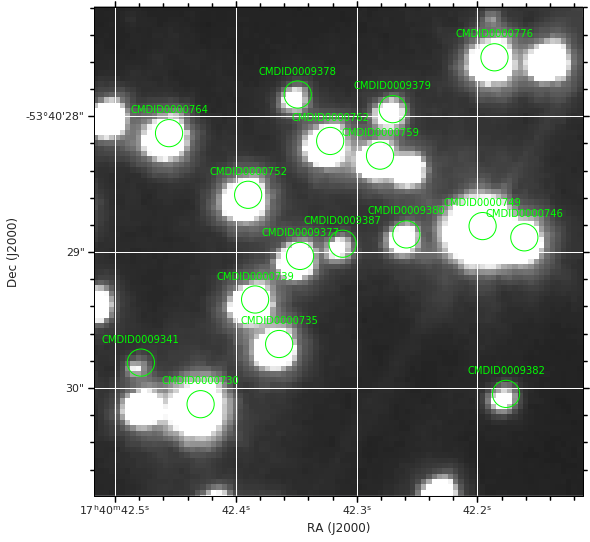

In [9]:
#region to plot
findreg = 'closestarsU19.reg'
listregs = []

with open(findreg,'w') as fileone:
    for index in idxcatalog:
            #text='circle({0},{1},.1") # color=blue text={2} \n'.format(ra[index],dec[index],'{'+str(ind[index])+"}")
            text='fk5;circle({0},{1},0.1") # color=green text={2} \n'.format(radeglist[index],decdeglist[index],'{CMDID'+str(name[index])+"}")
            listregs.append(text)
            #text='fk5; circle({0},{1},.1") # color=red text=\{{2}\}\n'.format(ra[index],dec[index],index)
            fileone.write(text)
            #print(text)


INFO: Auto-setting vmin to -1.018e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.275e+02 [aplpy.core]


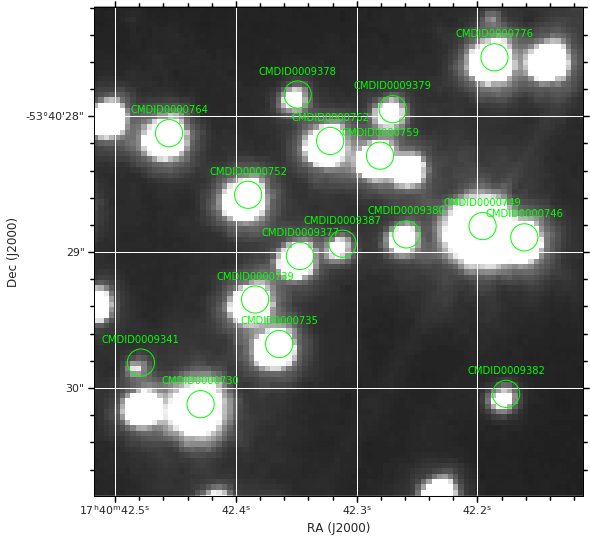

In [10]:
fig = aplpy.FITSFigure('hlsp_hugs_hst_acs-wfc_ngc6397_f606w_v1_stack-0015s.fits')
fig.show_grayscale()
fig.recenter(radeg, decdeg, width=0.001, height=0.001)  # degree
fig.show_regions(findreg)

INFO: Auto-setting vmin to -2.976e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.459e+03 [aplpy.core]


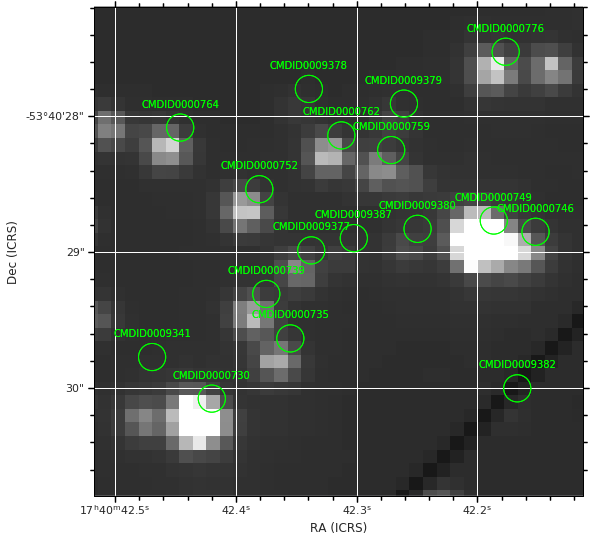

In [8]:
fig2 = aplpy.FITSFigure('FixeWCSofReference/Fixedu9710103m_c0m.chiptres.fits',north=True)
fig2.show_grayscale()
fig2.recenter(radeg, decdeg, width=0.001, height=0.001)  # degree
fig2.show_regions(findreg)
fig2.show_regions(findreg,'starsxandy.reg')

In [79]:
#fig2.show_regions('starsxandy.reg')

# U23 Light Curve

From the image it lookst atht it is 1087. It takes to long to plot the huge region file produced by dolphot

In [116]:
plotlc(outputfile,[1483],columnfile,namelist=['1483'])


sed '1484q;d'  outdir/out.photo
['266.18', '684.72']
125


In [73]:
t = getobjectdata(outputfile,1483)


sed '1484q;d'  outdir/out.photo
['266.18', '684.72']


In [78]:
for i,j in enumerate(t[0:33]):
    print(i+1,j)

1 0
2 1
3 266.18
4 684.72
5 2.26
6 541.4
7 -0.037
8 0.167
9 20
10 0.493
11 1
12 84524.5
13 1415.74
14 1.93e-08
15 3.68e-11
16 19.288
17 99.999
18 0.002
19 2.23
20 523.3
21 -0.037
22 0.168
23 0.493
24 0
25 808.5
26 12.15
27 2.19e-08
28 4.24e-10
29 19.147
30 99.999
31 0.021
32 1.41
33 51.7


In [117]:
datagoodmjd=  createdatadicclean(outputfile,1483,columnfile,name='1483',timeformat='mjd')
mjd, mag, dmag, obnames = datagoodmjd['time'], datagoodmjd['VEGAMAG'],datagoodmjd['errorsmag'], datagoodmjd['obnames']

sed '1484q;d'  outdir/out.photo
['266.18', '684.72']
125


In [88]:
indgood = np.where(mag < 19.5)[0]
mjd, mag, dmag, obnames = mjd[indgood], mag[indgood], dmag[indgood], obnames[indgood]
len(mjd)

116

# Compute Periodogram with Astropy

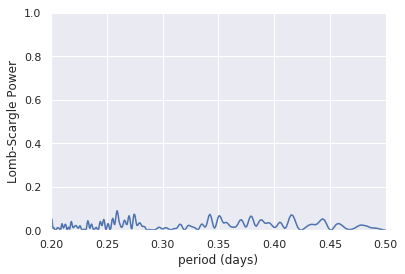

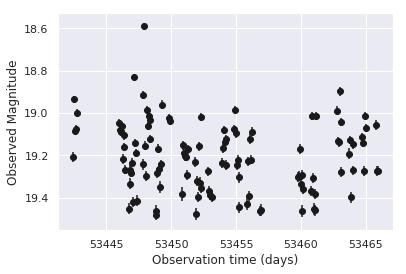

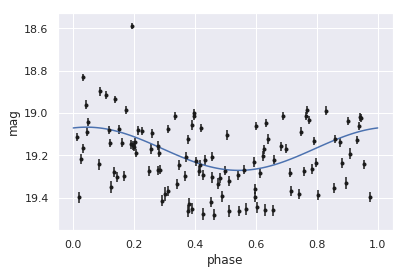

In [90]:


freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 0.5,
                                                maximum_frequency=1 / 0.01)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(mjd, mag, dmag).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

fig, ax = plt.subplots()

plt.plot(1. / freq, PLS)
ax.set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(0.2, 0.5),
          ylim=(0, 1));
plt.show()


fig, ax = plt.subplots()

# plot the raw data
ax.errorbar(mjd, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax.invert_yaxis()
ax.set(   xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

#plt.plot(t,mag_fit)



fig, ax = plt.subplots()
# plot the phased data & model in the inset
plt.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
plt.plot(phase_fit, mag_fit)


ax.invert_yaxis()
ax.set_xlabel('phase')
ax.set_ylabel('mag')
plt.show()

In [122]:
# Get a ``scanner'', which defines the frequency interval to be checked.
# Alternatively, also periods could be used instead of frequency.
S = pyPDM.Scanner(minVal=0.01, maxVal=0.1 ,dVal=0.0001, mode="period")

# Carry out PDM analysis. Get frequency array
# (f, note that it is frequency, because the scanner's
# mode is ``frequency'') and associated Theta statistic (t).
# Use 10 phase bins and 3 covers (= phase-shifted set of bins).
P = pyPDM.PyPDM(mjd, mag)
f1, t1 = P.pdmEquiBinCover(10, 3, S)

In [123]:

# Show the result

p = figure(plot_width=500, plot_height=500, title='',active_drag='pan', active_scroll='wheel_zoom',
           y_axis_label='Theta',x_axis_label='Period')

thetadic = {'theta':t1,
           'period':f1}  


        #Tool to get wavelength
hover2 = HoverTool(
        tooltips=[
            ('Date', '(@period)')
        ]
    )
p.add_tools(hover2)
p.line(x='period',y='theta',source=thetadic)
show(p)

In [126]:
bestperiod = 0.0668
phase,ind = P.phase(mjd,bestperiod)
summary = 'Best_frequency: {}, Period: {} days'.format(1/bestperiod,bestperiod)



p = figure(plot_width=700, plot_height=500, title=summary,active_drag='pan', active_scroll='wheel_zoom',
           y_axis_label='Mag',x_axis_label='Phase')

source = ColumnDataSource(data={'phase':phase[ind],
           'mag':mag[ind],
           'upper':mag[ind] + dmag[ind],
           'lower':mag[ind]-dmag[ind]})


  

p.y_range.flipped = True
p.circle(x='phase',y='mag',source=source)
# add a circle renderer with a size, color, and alpha
p.add_layout(
    Whisker(base="phase", upper="upper", lower="lower",source=source)
)
show(p)